## DJIA Stock Time Series Analysis ##
By: Sureet Sarau, Erik Martin, Ishraq Rahman

### Data ###
We will be using the [DJIA 30 Stock Time Series Dataset](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231/data?select=all_stocks_2006-01-01_to_2018-01-01.csv) from Kaggle.

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error,r2_score

### Data Cleaning and Exploration ###

Retrieve stock data from Apple (AAPL), Amazon (AMZN), Google (GOOGL), and IBM (IBM), Microsoft (MSFT).

In [232]:
# Initialize
output_file = "data/tech_stocks.csv"
tech_stock_codes = ['AAPL', 'AMZN', 'GOOGL', 'IBM', 'MSFT']

# Read in all stocks
all_stocks = pd.read_csv("data/all_stocks_2006-01-01_to_2018-01-01.csv")

# Filter for relevant stocks and save to a file
tech_stocks = all_stocks[all_stocks['Name'].isin(tech_stock_codes)]
tech_stocks.to_csv(output_file, index=False)


### Load and Transform Data ###

In [233]:
# Read in file
tech_df = pd.read_csv("data/tech_stocks_saved.csv")
# Filter out unneeded features
tech_df = tech_df.drop(columns=["Open", "High", "Low", "Volume"])
# Set Date as datetime
tech_df["Date"] = pd.to_datetime(tech_df["Date"])
# Pivot
tech_df = tech_df.pivot(index="Date", columns="Name", values="Close")
# Drop NaN values
tech_df = tech_df.dropna()
# Check dataframe
tech_df


Name,AAPL,AMZN,GOOGL,IBM,MSFT
Date,,,,,
2006-01-03,10.68,47.58,217.83,82.06,26.84
2006-01-04,10.71,47.25,222.84,81.95,26.97
2006-01-05,10.63,47.65,225.85,82.50,26.99
2006-01-06,10.90,47.87,233.06,84.95,26.91
2006-01-09,10.86,47.08,233.68,83.73,26.86
...,...,...,...,...,...
2017-12-22,175.01,1168.36,1068.86,152.50,85.51
2017-12-26,170.57,1176.76,1065.85,152.83,85.40
2017-12-27,170.60,1182.26,1060.20,153.13,85.71


### Visualize Raw Data ###

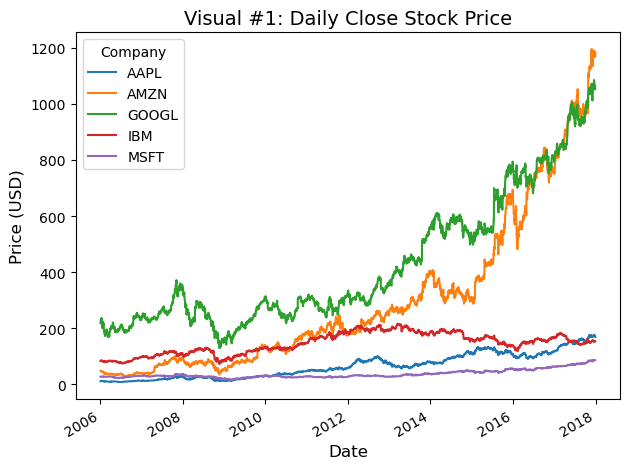

In [234]:
tech_df.plot(ax=plt.gca())
plt.title("Visual #1: Daily Close Stock Price", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(title="Company", fontsize=10)
plt.tight_layout()
plt.show()

# Analysis: Time Series Similarity #

### Gather Seasonality Components ###

In [235]:
def seasonality_decomp(df, model="additive"):
    """Helper function to extract additive seasonality of each tech stock"""
    # Normalize to weekly bins
    weekly = df.resample("W").mean()
    # Iterate through each company
    for company in weekly.columns:
        # Calculate additive seasonal decomposition for annual period
        result = seasonal_decompose(weekly[company], model=model, period=52)
        weekly[company] = result.seasonal
    return weekly

### Visualize Seasonality ###

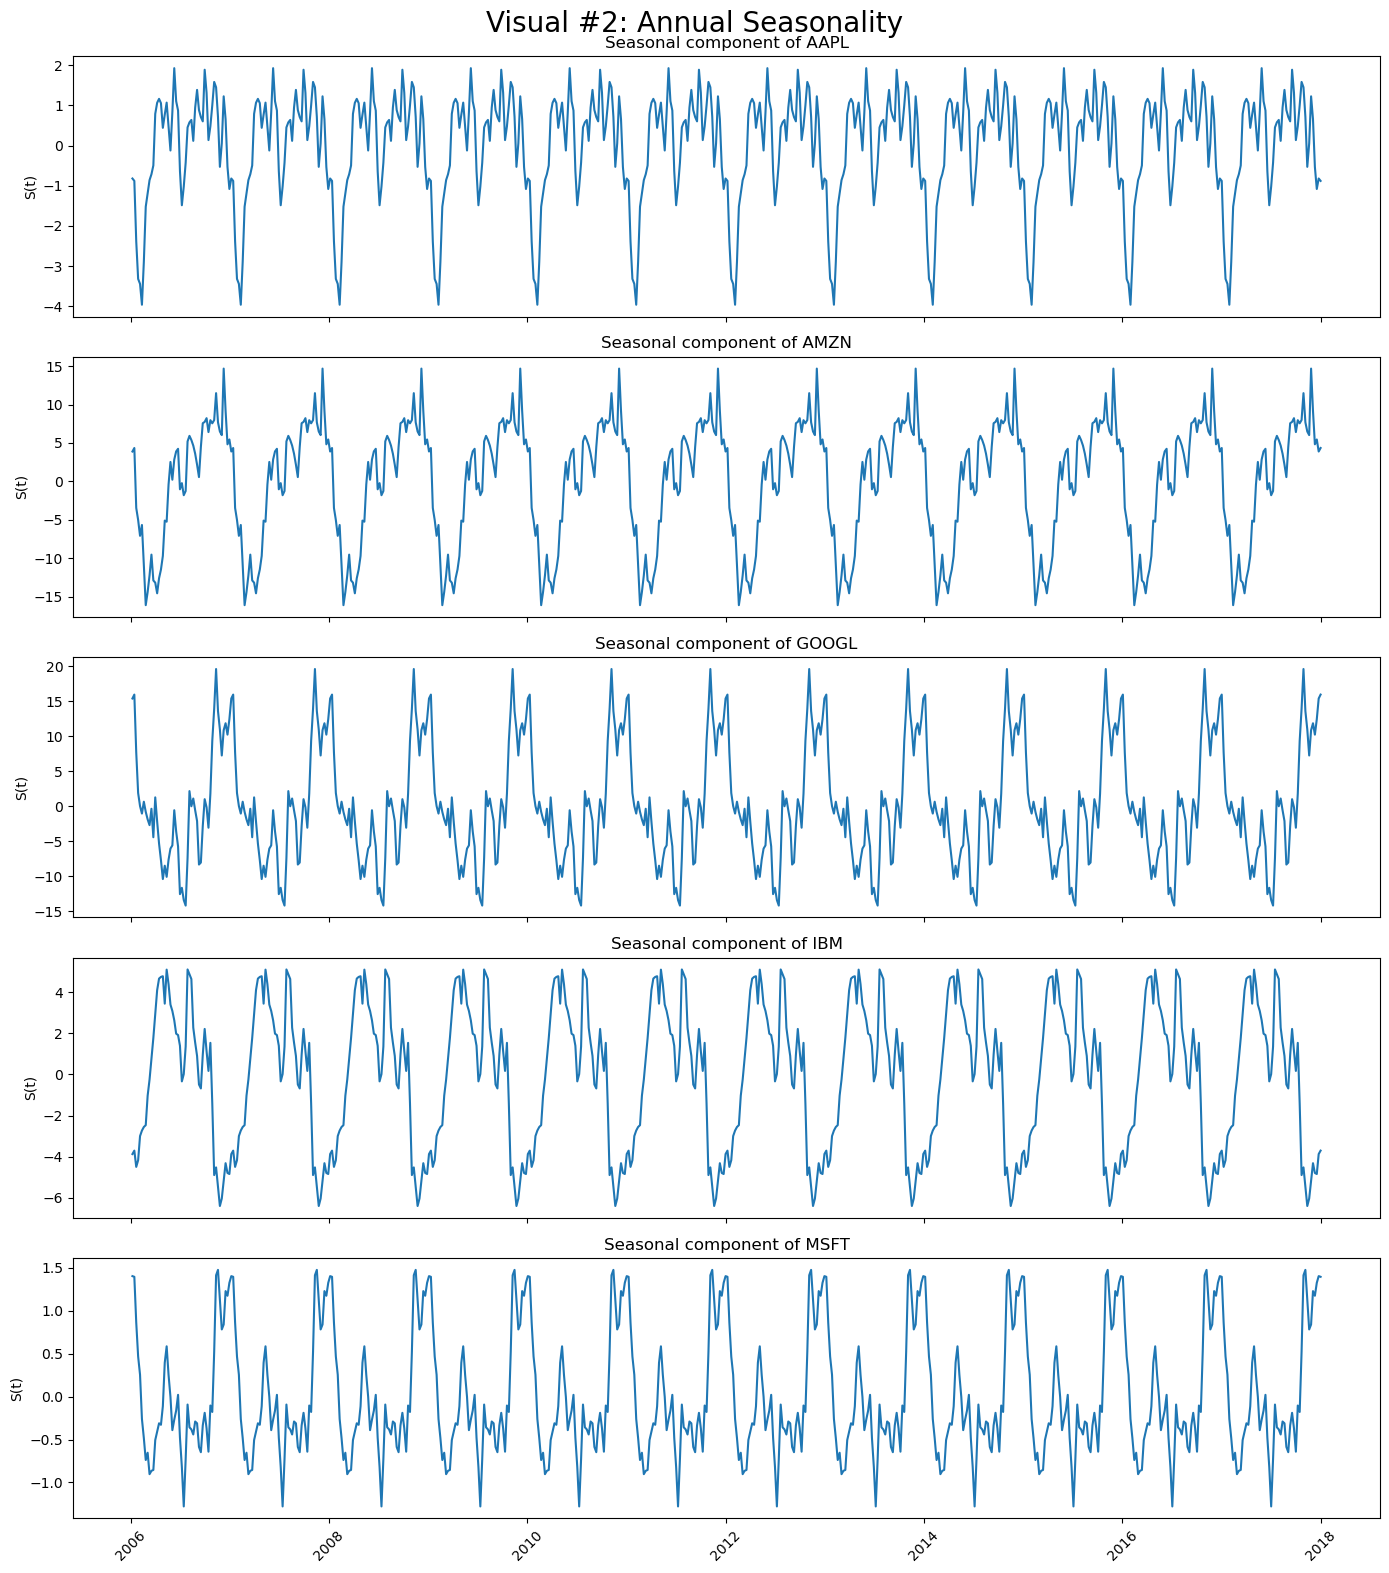

In [236]:
copy_df = tech_df.copy()
seasonal_df = seasonality_decomp(tech_df)

fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)
fig.suptitle("Visual #2: Annual Seasonality", fontsize=20)

for ax, stock in zip(axs, seasonal_df.columns):
    ax.plot(seasonal_df.index, seasonal_df[stock])
    ax.set_title(f"Seasonal component of {stock}")
    ax.set_ylabel("S(t)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Calculate Euclidean Distance ###

In [237]:
def calc_euclidean_dist(df):
    """Helper function to calculate Euclidean Distance of Seasonal df"""
    # initialize euclidean matrix & other variables
    countries = df.columns
    n = len(countries)
    dist_df = pd.DataFrame(np.zeros((n, n)), index=countries, columns=countries)

    # for each country pair
    for i in range(len(countries)):
        for j in range(len(countries)):
            # calc euclidean distance
            diff = df[countries[i]] - df[countries[j]]
            sq_sum = np.sum(diff ** 2)
            # place in matrix
            dist_df.iloc[i, j] = math.sqrt(sq_sum)

    return dist_df

In [15]:
euclidean_df = calc_euclidean_dist(seasonal_df)

### Calculate Cosine Similarity ###

In [239]:
def calc_cos_sim(df):
    """Helper function to calculate cosine similarity in a seasonality df"""
    # initialize cosine matrix & other variables
    countries = df.columns
    n = len(countries)
    sim_df = pd.DataFrame(np.zeros((n, n)), index=countries, columns=countries)

    # for each country pair
    for i in range(n):
        for j in range(n):
            # get vector
            x = df[countries[i]]
            y = df[countries[j]]
            # calculate dot product
            dot = np.sum(x * y)
            # calc magnitude
            x_mag = math.sqrt(np.sum(x ** 2))
            y_mag = math.sqrt(np.sum(y ** 2))
            # calc similarity
            cos_sim = dot / (x_mag * y_mag)
            # place in matrix
            sim_df.iloc[i, j] = cos_sim

    return sim_df

In [14]:
cos_df = calc_cos_sim(seasonal_df)

### Conduct Dynamic Time Warping ###

In [241]:
def calc_pairwise_dtw_cost(x, y, ret_matrix=False):
    """Helper function to calculate pairwise distance between stocks"""
    # initialize inputs and dtw_matrix
    x = np.array(x)
    y = np.array(y)
    n, m = len(x), len(y)
    dtw_matrix = np.full((m, n), np.inf)

    # loop through every cell in matrix
    for row in range(m):
        for col in range(n):
            cost = (x[col] - y[row]) ** 2
            # intialize
            if col == 0 and row == 0:
                dtw_matrix[row, col] = cost
            else:
                # get values
                left = dtw_matrix[row, col - 1]
                up = dtw_matrix[row - 1, col]
                diag = dtw_matrix[row - 1, col - 1]
                # apply cost based on min value
                dtw_matrix[row, col] = cost + min(left, up, diag)

    if ret_matrix:
        return dtw_matrix
    else:
        return dtw_matrix[m - 1][n - 1]

def calc_dtw_cost(df):
    """Create df of pairwise DTW values"""
    # Initialize dataframe
    countries = df.columns
    n = len(countries)
    dtw_df = pd.DataFrame(np.zeros((n, n)), index=countries, columns=countries)

    # for each country pair, compute distance
    for i in range(n):
        for j in range(n):
            x = df[countries[i]].values
            y = df[countries[j]].values
            dtw_df.iloc[i, j] = calc_pairwise_dtw_cost(x, y)

    return dtw_df

In [13]:
dtw_df = np.sqrt(calc_dtw_cost(tech_df.copy()))

In [27]:
print("Table #3: DTW\n")
dtw_df

Table #3: DTW



Name,AAPL,AMZN,GOOGL,IBM,MSFT
Name,,,,,
AAPL,0.000000,16399.339015,19973.289886,2100.262000,1269.890241
AMZN,16399.339015,0.000000,3718.339730,16550.245339,19288.378756
GOOGL,19973.289886,3718.339730,0.000000,19078.906057,23543.287517
IBM,2100.262000,16550.245339,19078.906057,0.000000,4423.289599
MSFT,1269.890241,19288.378756,23543.287517,4423.289599,0.000000


### Evaluation ###

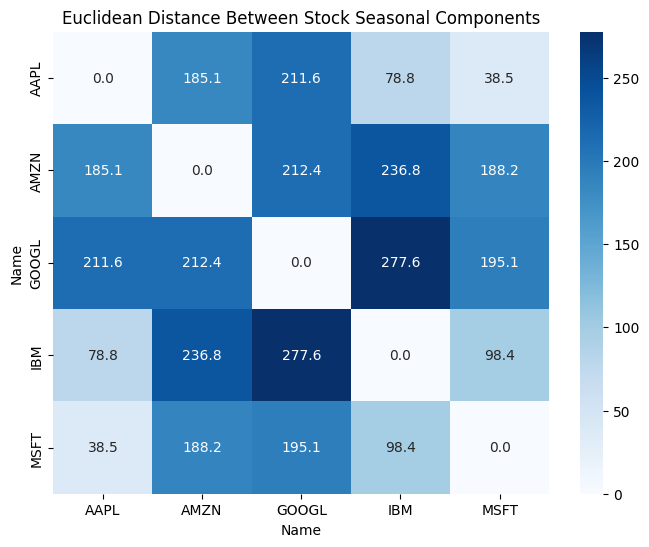

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(euclidean_df, annot=True, cmap="Blues", fmt=".1f")
plt.title("Euclidean Distance Between Stock Seasonal Components")
plt.show()


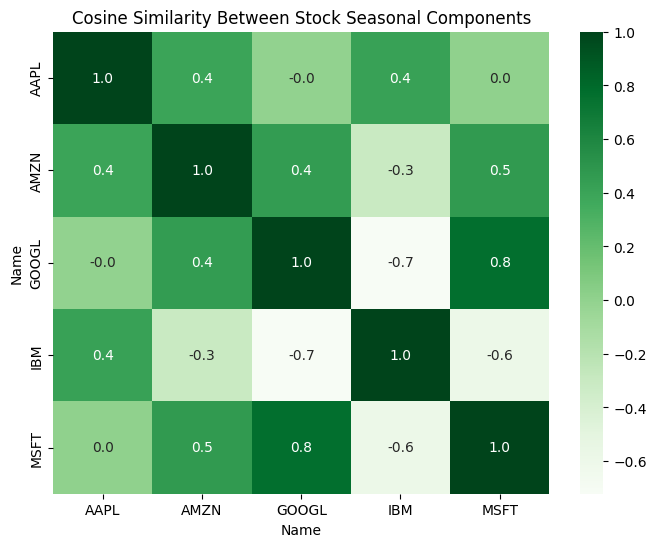

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(cos_df, annot=True, cmap="Greens", fmt=".1f")
plt.title("Cosine Similarity Between Stock Seasonal Components")
plt.show()


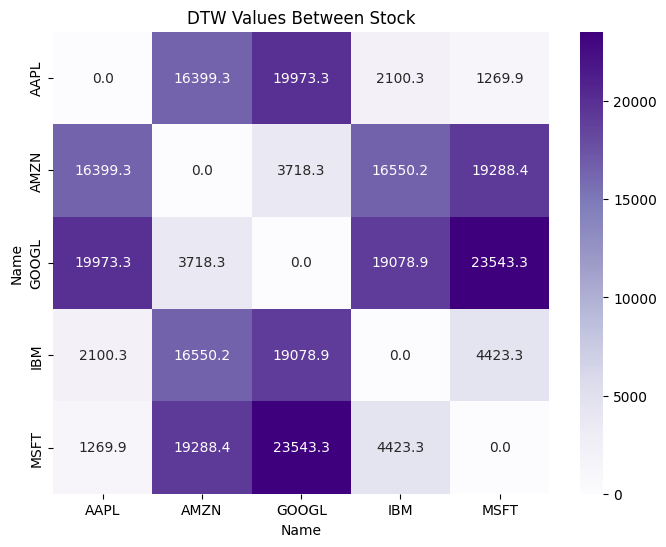

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(dtw_df, annot=True, cmap="Purples", fmt=".1f")
plt.title("DTW Values Between Stock")
plt.show()


# Analysis: Forecasting #

## Microsoft vs. Amazon ##

### Make Data Stationary ###

In [243]:
# calculate the weighted moving average
def calc_wma(ser, wd_size, weights=1):
        
    if isinstance(weights, int):
        weights = np.full(wd_size, weights, dtype=float)
    
    wma = []
    for i in range(len(ser)):
        low, high = max(0, i - wd_size + 1), i + 1
        wma.append(np.average(ser.iloc[low: high], weights=weights[-(high - low):]))
    return np.array(wma)

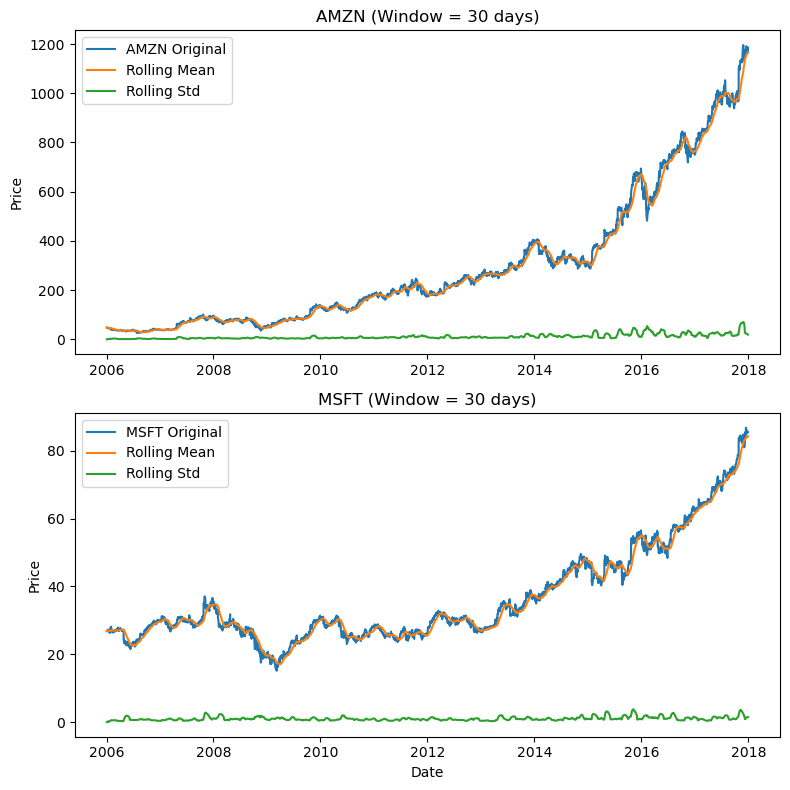

In [260]:
wd_size = 30
stocks = tech_df[["AMZN","MSFT"]].columns

fig, axes = plt.subplots(len(stocks), 1, figsize=(8, 4 * len(stocks)), sharex=False)

for ax, stock in zip(axes, stocks):

    series = tech_df[stock]

    first_mmt = calc_wma(series, wd_size)
    second_mmt = calc_wma(series**2, wd_size)

    rolling_mean = first_mmt
    rolling_std = np.sqrt(second_mmt - first_mmt**2)

    ax.plot(series, label=f"{stock} Original")
    ax.plot(pd.Series(rolling_mean, index=series.index), label="Rolling Mean")
    ax.plot(pd.Series(rolling_std, index=series.index), label="Rolling Std")

    ax.set_title(f"{stock} (Window = {wd_size} days)")
    ax.set_ylabel("Price")
    ax.legend()

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()


In [245]:
log_returns = np.log(tech_df).diff().dropna()

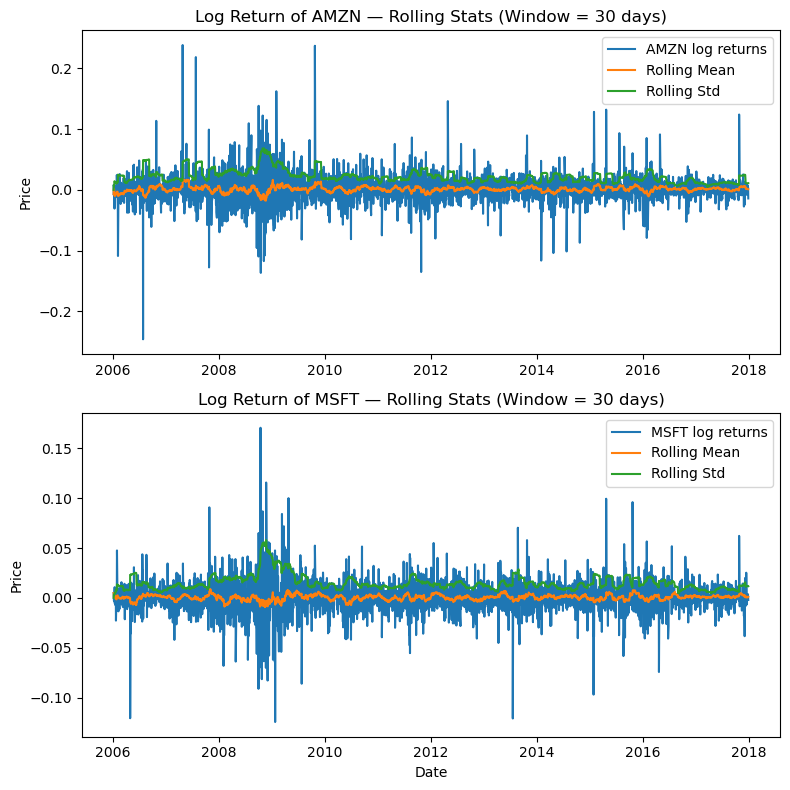

In [261]:
wd_size = 30
lr_stocks = log_returns[["AMZN","MSFT"]].columns

fig, axes = plt.subplots(len(lr_stocks), 1, figsize=(8, 4 * len(lr_stocks)), sharex=False)

for ax, stock in zip(axes, lr_stocks):

    series = log_returns[stock]

    first_mmt = calc_wma(series, wd_size)
    second_mmt = calc_wma(series**2, wd_size)

    rolling_mean = first_mmt
    rolling_std = np.sqrt(second_mmt - first_mmt**2)

    ax.plot(series, label=f"{stock} log returns")
    ax.plot(pd.Series(rolling_mean, index=series.index), label="Rolling Mean")
    ax.plot(pd.Series(rolling_std, index=series.index), label="Rolling Std")

    ax.set_title(f"Log Return of {stock} — Rolling Stats (Window = {wd_size} days)")
    ax.set_ylabel("Price")
    ax.legend()

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

### Test for Stationarity with ADF ###

In [247]:
_, pval, *_ = adfuller(tech_df['AMZN'])
print(f"AMZN p-value: {pval}")
_, pval, *_ = adfuller(log_returns['AMZN'])
print(f"Log Return AMZN p-value: {pval}\n")

_, pval, *_ = adfuller(tech_df['MSFT'])
print(f"MSFT p-value: {pval}")
_, pval, *_ = adfuller(log_returns['MSFT'])
print(f"Log Return MSFT p-value: {pval}\n")

AMZN p-value: 1.0
Log Return AMZN p-value: 0.0

MSFT p-value: 0.9988575993461946
Log Return MSFT p-value: 5.960479525536872e-25



### Plot Amazon ACF and PACF ###

Text(0, 0.5, 'Correlation')

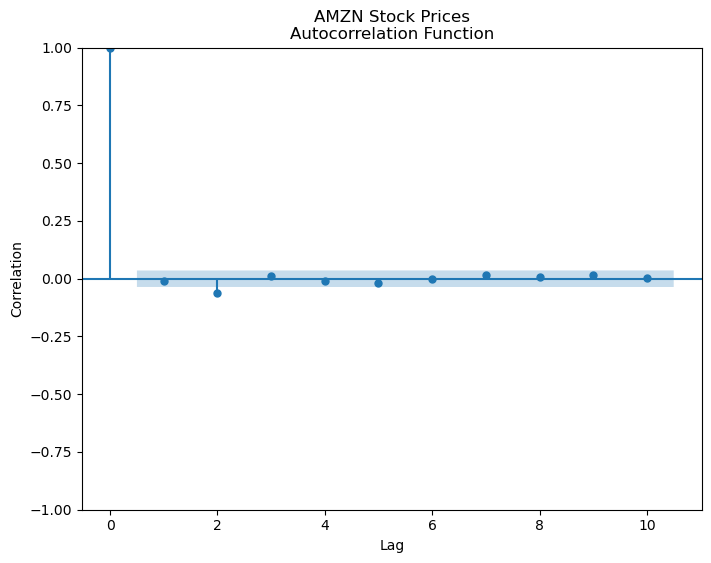

In [248]:
# Plot the AMZN ACF
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(log_returns["AMZN"], ax, lags=10, title="AMZN Stock Prices\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

Text(0, 0.5, 'Correlation')

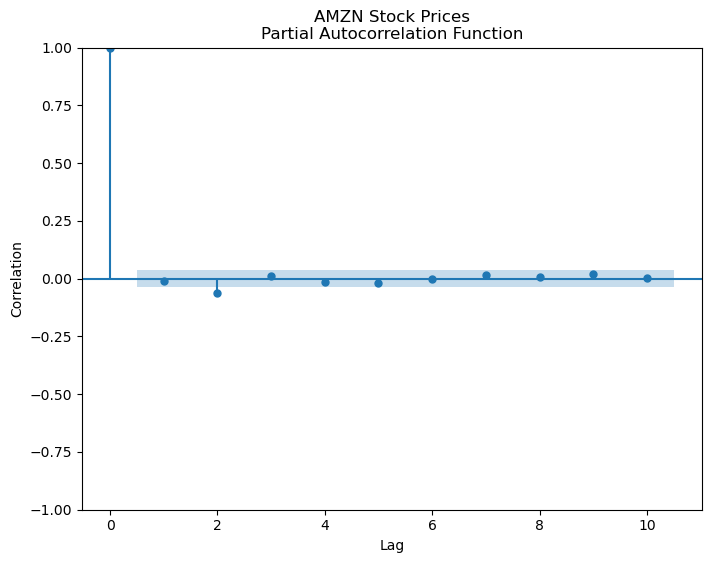

In [249]:
# Plot the AMZN PACF
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(log_returns["AMZN"], ax, lags=10, title="AMZN Stock Prices\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

### Fit Amazon ARIMA Model ###

In [250]:
model1 = ARIMA(log_returns["AMZN"], order=(1,0,1))
fit1 = model1.fit()


In [251]:
print(fit1.summary())


                               SARIMAX Results                                
Dep. Variable:                   AMZN   No. Observations:                 3018
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6862.368
Date:                Fri, 05 Dec 2025   AIC                         -13716.736
Time:                        11:23:18   BIC                         -13692.687
Sample:                             0   HQIC                        -13708.088
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.324      0.020       0.000       0.002
ar.L1         -0.0452      1.855     -0.024      0.981      -3.681       3.590
ma.L1          0.0369      1.857      0.020      0.9

### Plot Microsoft ACF and PACF ###

Text(0, 0.5, 'Correlation')

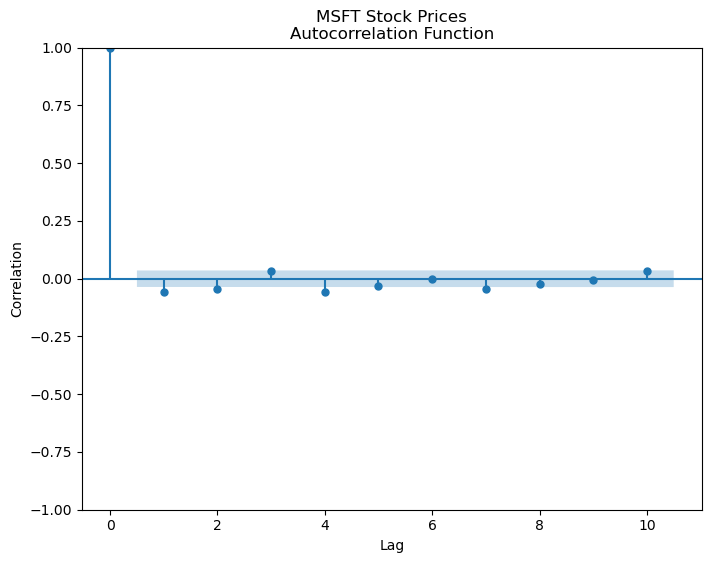

In [252]:
# Plot the MSFT ACF
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(log_returns["MSFT"], ax, lags=10, title="MSFT Stock Prices\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

Text(0, 0.5, 'Correlation')

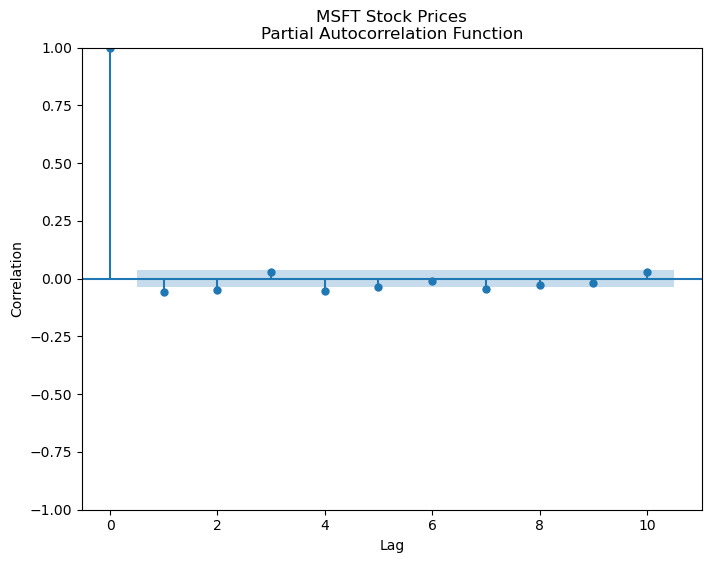

In [253]:
# Plot the MSFT PACF
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(log_returns["MSFT"], ax, lags=10, title="MSFT Stock Prices\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

### Fit Microsoft AMIRA Model ###

In [254]:
model2 = ARIMA(log_returns["MSFT"], order=(1,0,1))
fit2 = model2.fit()

In [255]:
print(fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                 3018
Model:                 ARIMA(1, 0, 1)   Log Likelihood                8036.674
Date:                Fri, 05 Dec 2025   AIC                         -16065.349
Time:                        11:23:22   BIC                         -16041.299
Sample:                             0   HQIC                        -16056.701
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.315      0.189      -0.000       0.001
ar.L1          0.1859      0.187      0.994      0.320      -0.181       0.552
ma.L1         -0.2446      0.186     -1.315      0.1

### Forecast Stock Prices ###

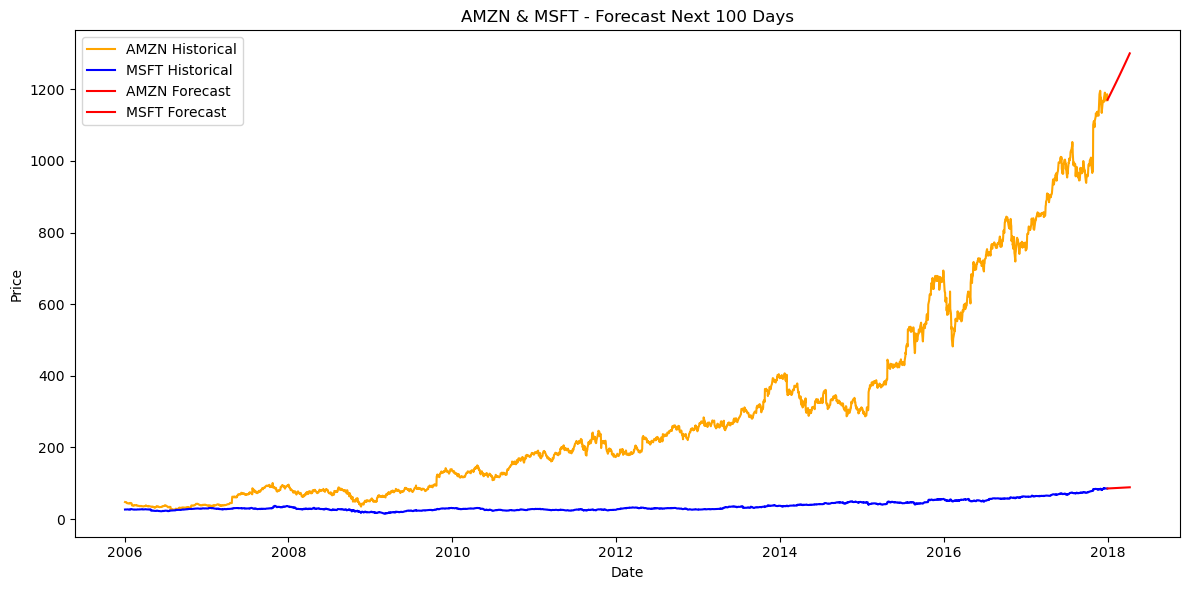

In [256]:
forecast_steps = 100
series_amzn = tech_df["AMZN"]
series_msft = tech_df["MSFT"]

forecast_returns_amzn = fit1.forecast(steps=forecast_steps)
forecast_returns_msft = fit2.forecast(steps=forecast_steps)

last_log_amzn = np.log(series_amzn.iloc[-1])
forecast_log_amzn = last_log_amzn + np.cumsum(forecast_returns_amzn)
forecast_prices_amzn = np.exp(forecast_log_amzn)

last_log_msft = np.log(series_msft.iloc[-1])
forecast_log_msft = last_log_msft + np.cumsum(forecast_returns_msft)
forecast_prices_msft = np.exp(forecast_log_msft)

forecast_index = pd.date_range(start=series_amzn.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_amzn, label="AMZN Historical", color="orange")
ax.plot(series_msft, label="MSFT Historical", color="blue")
ax.plot(forecast_index, forecast_prices_amzn, color="red", label="AMZN Forecast")
ax.plot(forecast_index, forecast_prices_msft, color="red", label="MSFT Forecast")

ax.set_title(f"AMZN & MSFT - Forecast Next {forecast_steps} Days")
ax.set_ylabel("Price")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()

### Amazon Goodness of Fit ###

In [257]:
y_true = log_returns["AMZN"]
y_pred = fit1.fittedvalues

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

r2 = r2_score(y_true, y_pred)
print("R²:", r2)


RMSE: 0.024903380960747356
R²: 3.326041076867625e-05


### Microsoft Goodness of Fit ###

In [258]:
y_true = log_returns["MSFT"]
y_pred = fit2.fittedvalues

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

r2 = r2_score(y_true, y_pred)
print("R²:", r2)

RMSE: 0.016876162757032676
R²: 0.0043259137993095775
